In [1]:
import pandas as pd
import numpy as np
import MarineDNA as md
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px

In [2]:
file1 = "../../../Data/Flyer2018_16S_table_counts.tsv"
asvs1 = pd.read_csv(file1, index_col=0, sep="\t")

### Scores Distribution

In [3]:
def plotScoreDistribution(scores, x = 0, y = 1):
    import pandas as pd
    import numpy as np
    import plotly.offline as pyo
    import plotly.graph_objs as go
    
    score_list = md.harmonizeColumnSigns_std(scores)
    score_arr = np.stack(score_list, axis = 2)

    median_score = pd.DataFrame([[np.median(score_arr[row, col, :]) for col in range(score_arr.shape[1])] for row in range(score_arr.shape[0])])
    min_score = pd.DataFrame([[np.min(score_arr[row, col, :]) for col in range(score_arr.shape[1])] for row in range(score_arr.shape[0])])
    max_score = pd.DataFrame([[np.max(score_arr[row, col, :]) for col in range(score_arr.shape[1])] for row in range(score_arr.shape[0])])

    medians = go.Scatter(
        x = median_score.iloc[:, 0],
        y = median_score.iloc[:, 1],
        mode = 'markers'
    )

    horiz_lines = [
        dict(
            type = 'line',
            x0 = min_score.iloc[i, 0],
            y0 = median_score.iloc[i, 1],
            x1 = max_score.iloc[i, 0],
            y1 = median_score.iloc[i, 1],
            line = dict(
                color = 'grey',
                width = 1
            )
        )
        for i in range(median_score.shape[0])
    ]

    vert_lines = [
        dict(
            type = 'line',
            x0 = median_score.iloc[i, 0],
            y0 = min_score.iloc[i, 1],
            x1 = median_score.iloc[i, 0],
            y1 = max_score.iloc[i, 1],
            line = dict(
                color = 'grey',
                width = 1
            )
        )
        for i in range(median_score.shape[0])
    ]

    go.Figure(
        medians, 
        go.Layout(shapes = horiz_lines + vert_lines, autosize = False, width = 1000, height = 1000)
    ).show()

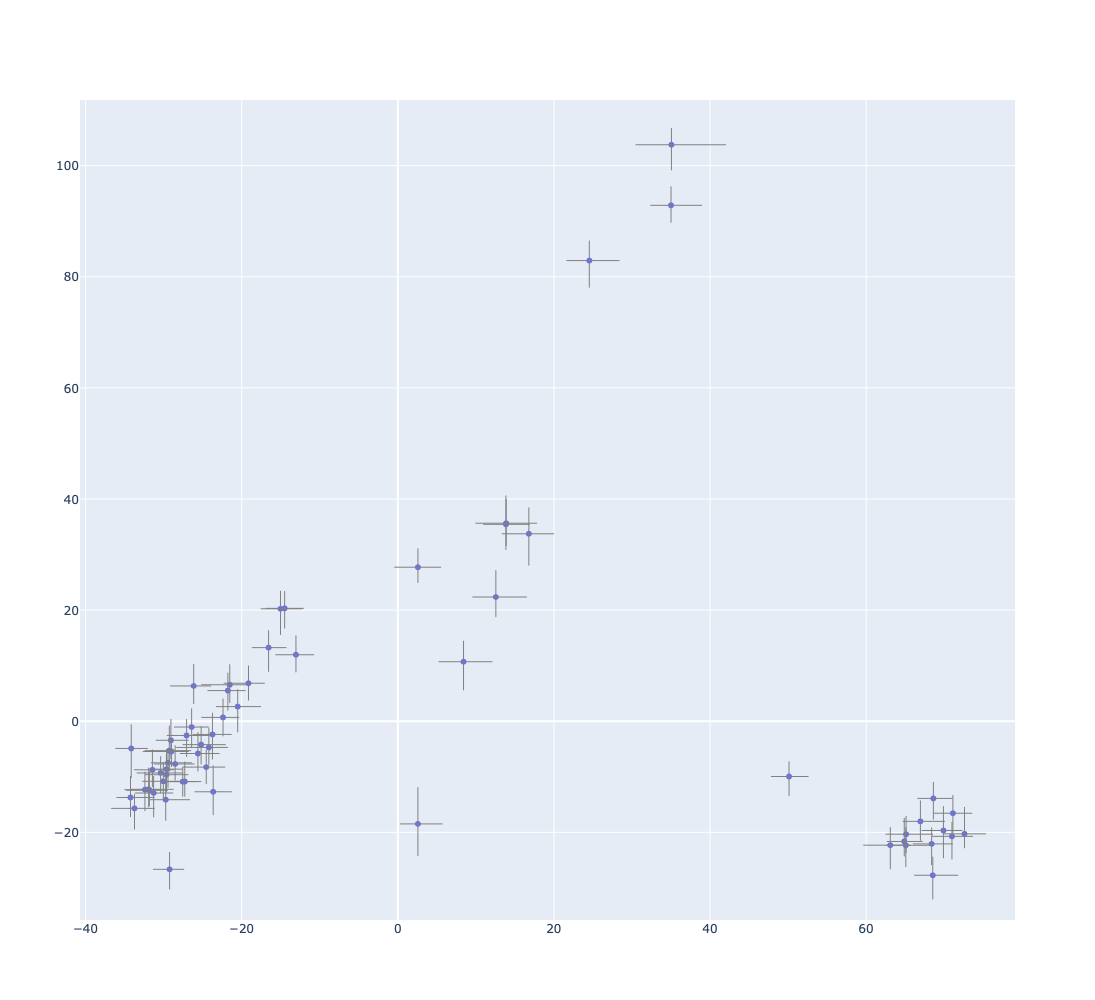

In [4]:
sample_scores = [md.doPCA(md.ranRelPct(asvs1))["scores"] for i in range(100)]
plotScoreDistribution(sample_scores)

### Loadings Distribution

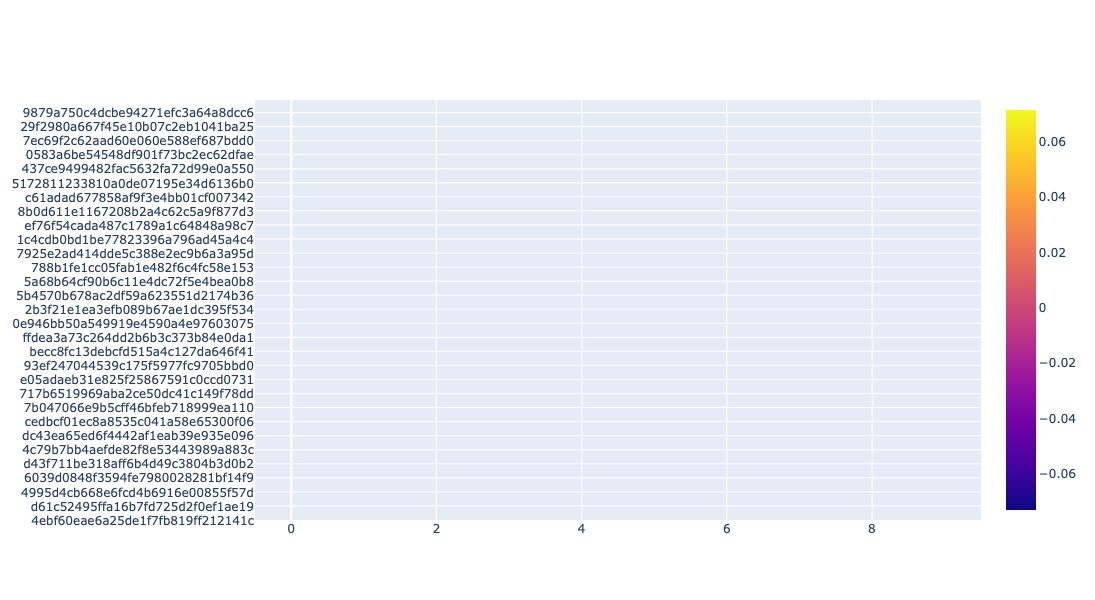

In [5]:
raw_loadings = [md.doPCA(md.ranRelPct(asvs1))["loadings"] for i in range(10)]
df = md.sortLoadings_std(raw_loadings, 0, asvs1.transpose().columns.values)
go.Figure(go.Heatmap(y = df.index[:-1], z = df.iloc[::-1]), go.Layout(autosize = False, width = 1000, height = 600))

### Loading Outlier Detection

In [6]:
def iqrThresh(x):
    quarts = np.quantile(x, [0.25, 0.75])
    iqr = np.diff(quarts)
    lower = quarts[0] - 1.5 * iqr
    upper = quarts[1] + 1.5 * iqr
    return [lower, upper]
    
iqrThresh(df.iloc[:,0])

[array([-0.01876398]), array([0.02623306])]

In [7]:
def isOutlier(x):
    thresh = iqrThresh(x)
    return [xi <= thresh[0] or xi >= thresh[1] for xi in x]

type(isOutlier(df.iloc[:,0]))

list

In [8]:
# need to figure out how to turn this into a data frame
outliers = [isOutlier(df.iloc[:,i]) for i in range(df.shape[1])]